The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. - DONE
* Apply a distortion correction to raw images. - DONE
* Use color transforms, gradients, etc., to create a thresholded binary image. - DONE
* Apply a perspective transform to rectify binary image ("birds-eye view"). - DONE
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [38]:
# import useful libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
import pickle

from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.metrics import recall_score,precision_score,f1_score

from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import os

# utilities libraries
import random

# import video editting libraries
from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [20]:
test_images = glob.glob(('test_images/*.jpg'))

print(test_images)

['test_images/sobel_test_lane_finding.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


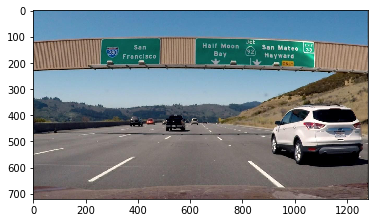

In [21]:

# Read in an image
image = mpimg.imread(test_images[0])
plt.imshow(image)


FUNCTIONS: Color and Gradient Thresholding

In [22]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0,sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(grey,cv2.CV_64F,1,0,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(grey,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    print("range of abs sobel",np.min(scaled_sobel),np.max(scaled_sobel),np.median(scaled_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # return matrix with true or false
    # then do we merge the two?
    mask = (scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])
    print(mask.shape)
    binary_output = np.zeros_like(grey)
    binary_output[mask] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    dimensions = ['x','y']
    sobel_dim = []
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    for dim in dimensions:
        if dim == 'x':
            sobel = cv2.Sobel(grey,cv2.CV_64F,1,0,ksize=sobel_kernel)
        else:
            sobel = cv2.Sobel(grey,cv2.CV_64F,0,1,ksize=sobel_kernel)
        sobel_dim.append(sobel)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.add(sobel_dim[0]**2,sobel_dim[1]**2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * mag_sobel / np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mask = (scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])
    binary_output = np.zeros_like(grey)
    binary_output[mask] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    dimensions = ['x','y']
    sobel_dim = []
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    for dim in dimensions:
        if dim == 'x':
            sobel = cv2.Sobel(grey,cv2.CV_64F,1,0,ksize=sobel_kernel)
        else:
            sobel = cv2.Sobel(grey,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients    
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        #scaled_sobel = abs_sobel
        sobel_dim.append(scaled_sobel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_sobel = np.arctan2(sobel_dim[1],sobel_dim[0])
    # 5) Create a binary mask where direction thresholds are met
    mask = (dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])
    binary_output = np.zeros_like(grey)
    binary_output[mask] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# next step use yuv color space. this seems pretty effective and then combine to apply naive method of lane finding

def color_space_threshold(image,thresh=(0, 255),color_space = 'HLS',color_channel = 2):
    
    # convert image to yuv space
    if color_space == 'HLS':
        cvt_image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
        
    cvt_image = cvt_image[:,:,color_channel]
    # goal is to detect lanes or lines. then probably saturation is the best here.

    # play with threshold to see how to isolate lanes
    binary_mask = (cvt_image > thresh[0]) & (cvt_image <= thresh[1])
    binary_output = np.zeros_like(cvt_image)
    binary_output[binary_mask] = 1
    
    return binary_output


('range of abs sobel', 0, 255, 1.0)
(720, 1280)
('range of abs sobel', 0, 255, 2.0)
(720, 1280)


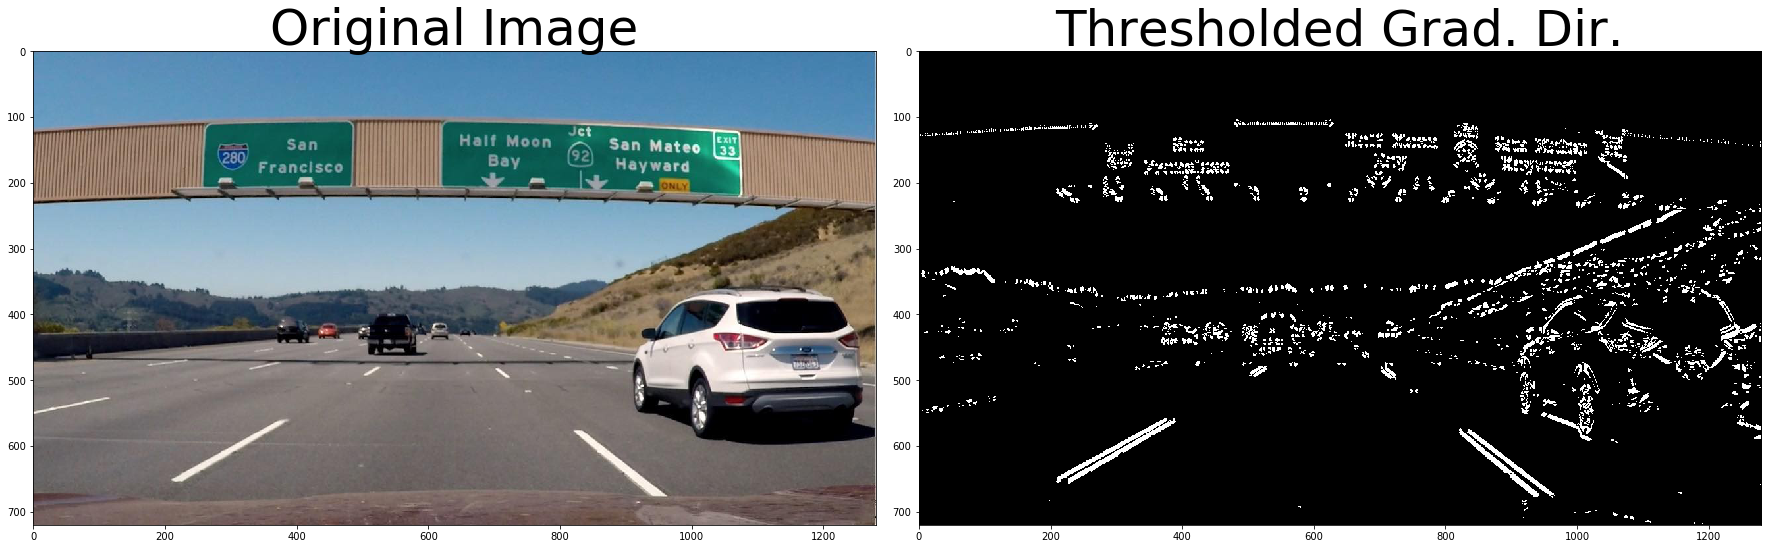

In [23]:
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 200))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[(mag_binary == 1) ] = 1
#combined[(dir_binary == 1) ] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [24]:
def plot_img_list (img_list,rows,list_type = 'images'):
    
    cols = int((len(img_list)) / rows)
    fig, axs = plt.subplots(rows,cols, figsize=(16,8 )) # this creates x subplots with each subplot with width and heigh
    axs = axs.ravel()

    for counter,img in enumerate(img_list):
        if list_type != 'images':
            img = mpimg.imread(img)
        axs[counter].imshow(img)


FUNCTIONS: Camera Calibration and Undistort Image

In [25]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# Given board size of 9 blocks across and 6 blocks down

def get_chessboard_corners(exp_corners_x,exp_corners_y,img_file_list):

    # create zero array that stores x, y, z
    objpts = np.zeros((6*9,3), np.float32)
    objpts[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints=[]# 3d points in real world space
    imgpoints=[] # 2d points in image plane.
    imges = []

    # Make a list of calibration images
    images = img_file_list 
    images.sort()

    # Step through the list and search for chessboard corners
    for img_file in images:

        img = mpimg.imread(img_file)
        grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        retval,corners = cv2.findChessboardCorners(grey,(nx,ny),None)

        # If found, add object points, image points
        if retval:
            objpoints.append(objpts)
            imgpoints.append(corners)
            #print("corners found")
            # Draw and display the corners
            cv2.drawChessboardCorners(img,(nx,ny),corners,retval)
            imges.append(img)
        else:
            print("corners not found", img_file)
            
    return objpoints,imgpoints,imges

def undistort_img(objpoints,imgpoints,img_file_name):

    #load images
    img = mpimg.imread(img_file_name)
    grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img_size = (img.shape[1],img.shape[0])

    # get camera matrix
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # then get undistorted
    dst = cv2.undistort(img, mtx, dist,None,mtx)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title("original image")
    
    ax2.imshow(dst)
    ax2.set_title("undistorted image")
    
    return dst



1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

('corners not found', 'camera_cal/calibration1.jpg')
('corners not found', 'camera_cal/calibration4.jpg')
('corners not found', 'camera_cal/calibration5.jpg')


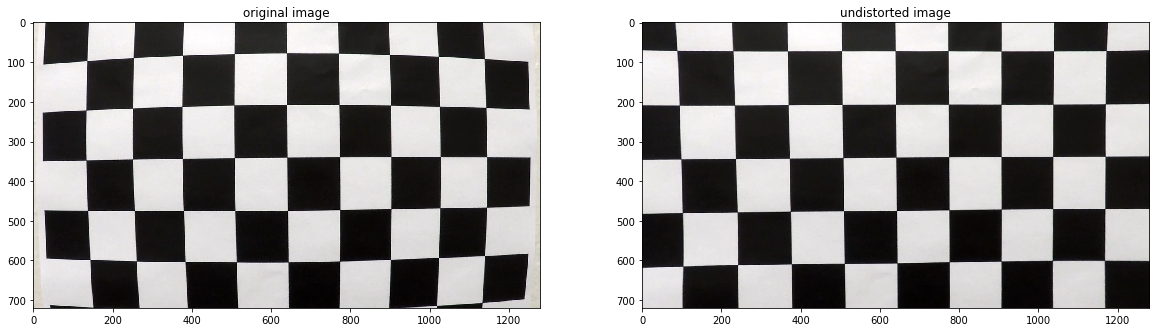

In [26]:
nx = 9
ny = 6

img_files = glob.glob('camera_cal/calibration*.jpg')

objpoints,imgpoints,imges = get_chessboard_corners(nx,ny,img_files)

#plt.imshow(imges[0])
#plot_img_list(imges,4)

img_undistorted = undistort_img(objpoints,imgpoints,img_files[0])

* Apply a distortion correction to raw images.

['test_images/sobel_test_lane_finding.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


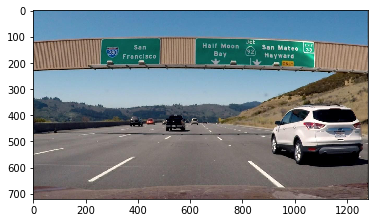

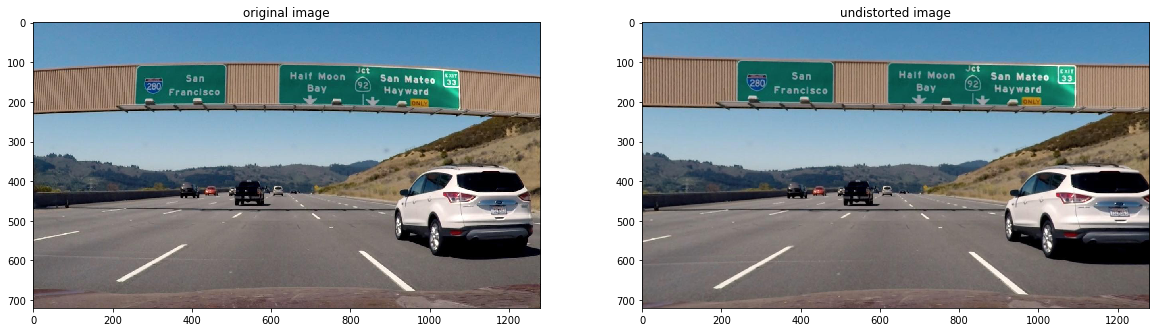

In [27]:
# First get 1 test images

test_images_files = glob.glob("test_images/**test*.jpg")
print(test_images_files)

image = mpimg.imread(test_images_files[0])
plt.imshow(image)

# can we measure the amount of distortion?
img_undistorted = undistort_img(objpoints,imgpoints,test_images_files[0])


* Use color transforms, gradients, etc., to create a thresholded binary image.

('range of abs sobel', 0, 255, 1.0)
(720, 1280)
(0, 1)
('range of abs sobel', 0, 255, 1.0)
(720, 1280)


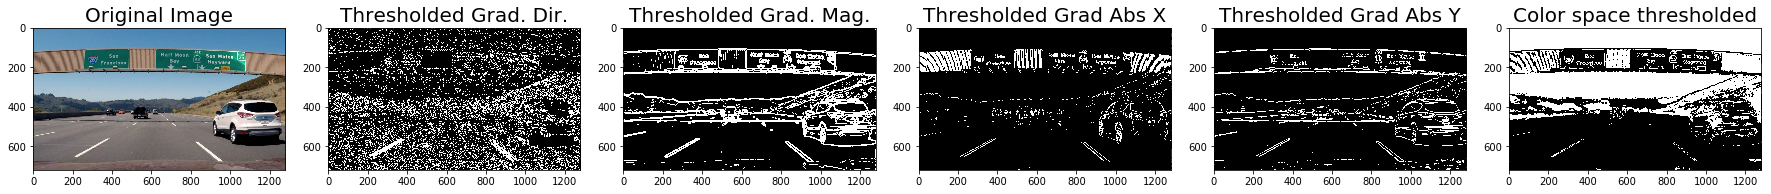

In [28]:
# Run the function
#radian, 0 deg = horizontal, 90 deg vertical. pi = 180, pi/2 = 90
#odd this seems to filter out vertical lines
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

#intuition behind magnitude?
mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(20, 255))

# 0 = black and 1 = white. white means a gradient is detected
# x does vertical lines
# basically, we want to weed out the black units. so the lower threshold is more important
abs_sobel_binary_x = abs_sobel_thresh(image, 'x', thresh_min=0,sobel_kernel=3, thresh=(20, 255))
print(np.min(abs_sobel_binary_x),np.max(abs_sobel_binary_x)) # range is too big then everything is 1
# y does horizontal lines
abs_sobel_binary_y = abs_sobel_thresh(image, 'y', thresh_min=0,sobel_kernel=3, thresh=(20, 255))

color_space_binary = color_space_threshold(image,thresh=(50, 150),color_space = 'HLS',color_channel = 2)

# Plot the result
font_size_val = 20
f, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(1, 6, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=font_size_val)

ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=font_size_val)

ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('Thresholded Grad. Mag.', fontsize=font_size_val)

ax4.imshow(abs_sobel_binary_x, cmap='gray')
ax4.set_title('Thresholded Grad Abs X', fontsize=font_size_val)

ax5.imshow(abs_sobel_binary_y, cmap='gray')
ax5.set_title('Thresholded Grad Abs Y', fontsize=font_size_val)

ax6.imshow(color_space_binary, cmap='gray')
ax6.set_title('Color space thresholded', fontsize=font_size_val)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

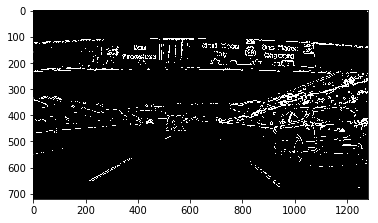

In [29]:
#combined thresholding

# all for now

combined_img = np.zeros_like(image[:,:,0])
#combined_mask = (dir_binary>0) & (mag_binary>0) & (abs_sobel_binary_x>0) & (abs_sobel_binary_y>0) &(color_space_binary>0)
#combined_mask = (mag_binary>0) & (abs_sobel_binary_x>0) & (color_space_binary>0)
combined_mask = (mag_binary>0) & (color_space_binary>0)
combined_img[combined_mask] = 1
#it's good but filter out alot here
plt.imshow(combined_img,cmap='gray')

#TODO
#1. Could we use math to find optimal? i.e highlight lane and non lane and max the number of pixesl
#2. Is there a way to loop through the number of combinations
#3. Optimize later. naive first

* Apply a perspective transform to rectify binary image ("birds-eye view").

In [67]:
# Choose to abstract source points, that way we can always use diff ways to get source
def get_birdeye_image_perspective(img,src,dst_offset):
    # 1. Add four corners of the lanes. i.e should form a trapezium
    img_size = (img.shape[1],img.shape[0])

    dst_offset = dst_offset

    # Order of corners is as follows
    ##### 1 ----- 2 #####
    ##### 4 ----- 3 #####

    #format x,y
    
    dst = np.float32([ [dst_offset,dst_offset],
                                    [img_size[0]-dst_offset,dst_offset],
                                    [img_size[0]-dst_offset,img_size[1]],
                                    [dst_offset,img_size[1]]
                                    ])
    
    #print("src points",src)
    #print("dst points",dst)

    x=np.hstack([src[:,0],src[0,0]])
    y=np.hstack([src[:,1],src[0,1]])

    ## plot original image with lane boundaries
    #fig,(ax1,ax2)  = plt.subplots(1,2,figsize=(16,8))
    #ax1.imshow(img)
    #ax1.plot(x,y, color='#33cc99', alpha=0.4, linewidth=5, solid_capstyle='round', zorder=2)

    # 2. then apply perspective transform. given source and destination point
    ## a. Get transform matrix
    mtrix = cv2.getPerspectiveTransform(src,dst)
    ## b. Apply transform matrix
    trans_image = cv2.warpPerspective(img,mtrix,img_size)
    ax2.imshow(trans_image)
    
    return trans_image


def get_birdeye_invers_matrix(img,src,dst_offset):
    # 1. Add four corners of the lanes. i.e should form a trapezium
    img_size = (img.shape[1],img.shape[0])

    dst_offset = dst_offset

    # Order of corners is as follows
    ##### 1 ----- 2 #####
    ##### 4 ----- 3 #####

    #format x,y
    
    dst = np.float32([ [dst_offset,dst_offset],
                                    [img_size[0]-dst_offset,dst_offset],
                                    [img_size[0]-dst_offset,img_size[1]],
                                    [dst_offset,img_size[1]]
                                    ])
    
    #print("src points",src)
    #print("dst points",dst)

    x=np.hstack([src[:,0],src[0,0]])
    y=np.hstack([src[:,1],src[0,1]])

    ## plot original image with lane boundaries
    #fig,(ax1,ax2)  = plt.subplots(1,2,figsize=(16,8))
    #ax1.imshow(img)
    #ax1.plot(x,y, color='#33cc99', alpha=0.4, linewidth=5, solid_capstyle='round', zorder=2)

    # 2. then apply perspective transform. given source and destination point
    ## a. Get transform matrix
    mtrix = cv2.getPerspectiveTransform(dst,src)
    ## b. Apply transform matrix
    #trans_image = cv2.warpPerspective(img,mtrix,img_size)
    #ax2.imshow(trans_image)
    
    return mtrix



First test for straight lines

['test_images/sobel_test_lane_finding.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']
('src points', array([[  575.,   460.],
       [  705.,   460.],
       [ 1180.,   720.],
       [  150.,   720.]], dtype=float32))
('dst points', array([[  100.,   100.],
       [ 1180.,   100.],
       [ 1180.,   720.],
       [  100.,   720.]], dtype=float32))
('src points', array([[  575.,   460.],
       [  705.,   460.],
       [ 1180.,   720.],
       [  150.,   720.]], dtype=float32))
('dst points', array([[  100.,   100.],
       [ 1180.,   100.],
       [ 1180.,   720.],
       [  100.,   720.]], dtype=float32))


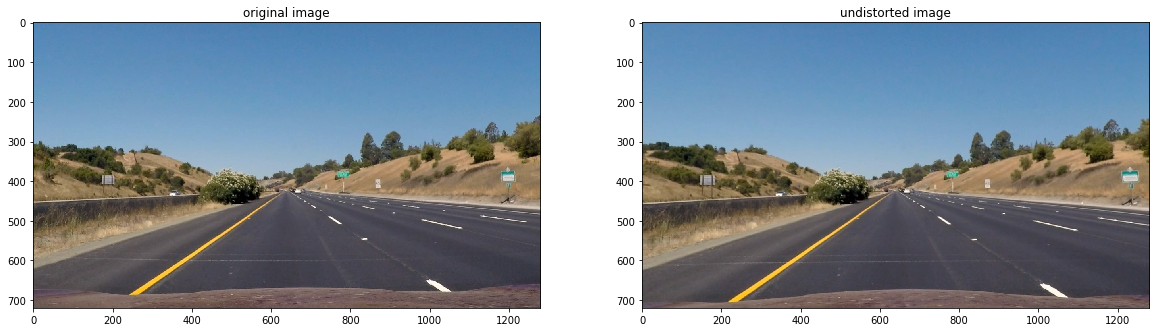

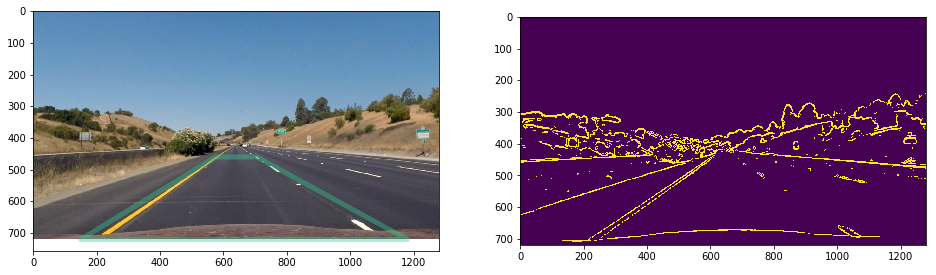

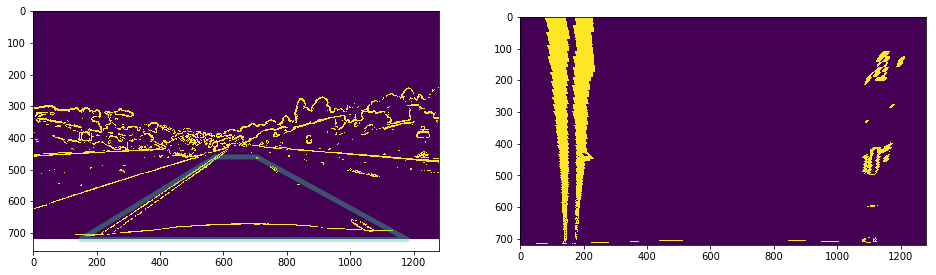

In [31]:
test_images_files = glob.glob("test_images/*.jpg")
print(test_images_files)

image = mpimg.imread(test_images_files[1])

image_undist = undistort_img(objpoints,imgpoints,test_images_files[1])
plt.imshow(image_undist)

image = image_undist

# choose to abstract this out. ideally we should get the lane start from the binary images
src_offset_x_btm_left = 150
src_offset_x_btm_right = 100
src_offset_x_top_left = 575
src_offset_x_top_right = 575
src_start_y = 460

dst_offset = 100

img_size = (image.shape[1],image.shape[0])

#format x,y
src = np.float32([ [src_offset_x_top_left,src_start_y],
                                [img_size[0]-src_offset_x_top_right,src_start_y],
                                [img_size[0]-src_offset_x_btm_right,img_size[1]],
                                [src_offset_x_btm_left,img_size[1]]
                                ])

trans_image = get_birdeye_image_perspective(image,src,dst_offset)

combined_img = np.zeros_like(image[:,:,0])
mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(50, 255))
color_space_binary = color_space_threshold(image,thresh=(10, 150),color_space = 'HLS',color_channel = 2)


combined_mask = (mag_binary>0) & (color_space_binary>0)
#combined_mask = (mag_binary>0) #& (color_space_binary>0)
combined_img[combined_mask] = 1
plt.imshow(combined_img)
trans_image = get_birdeye_image_perspective(combined_img,src,dst_offset)

Now test for curve lanes

['test_images/sobel_test_lane_finding.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']
('source points', array([[  560.,   450.],
       [  720.,   450.],
       [ 1190.,   720.],
       [  170.,   720.]], dtype=float32))
('src points', array([[  560.,   450.],
       [  720.,   450.],
       [ 1190.,   720.],
       [  170.,   720.]], dtype=float32))
('dst points', array([[  100.,   100.],
       [ 1180.,   100.],
       [ 1180.,   720.],
       [  100.,   720.]], dtype=float32))


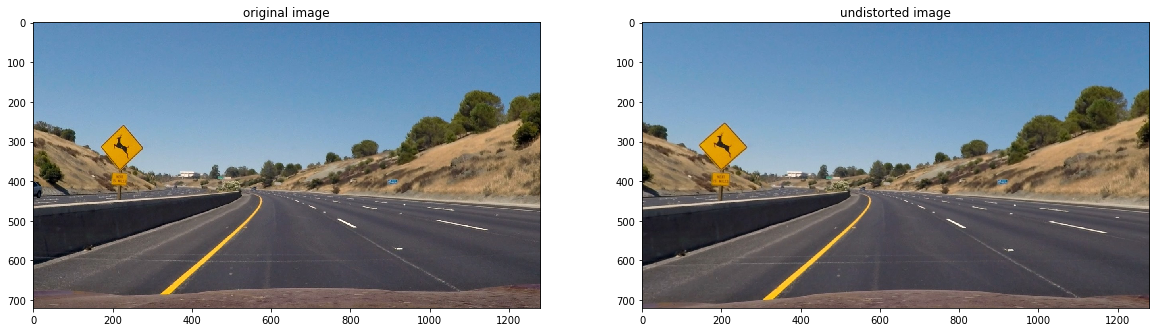

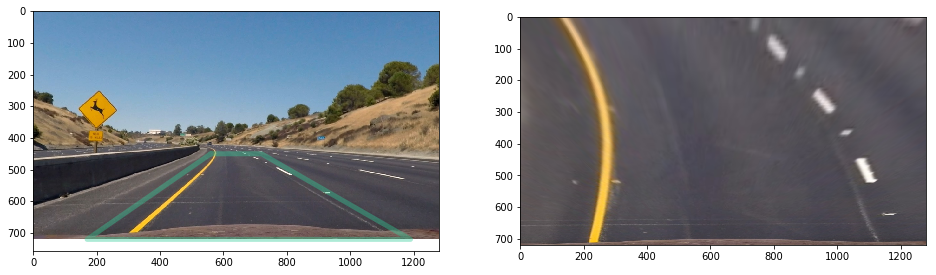

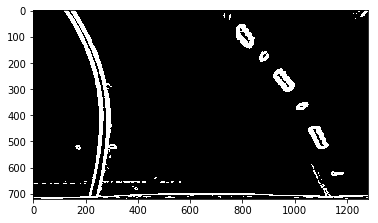

In [32]:
# nice it works. it's still somewhat parallel

test_images_files = glob.glob("test_images/*.jpg")
print(test_images_files)

image = mpimg.imread(test_images_files[4])

image_undist = undistort_img(objpoints,imgpoints,test_images_files[4])
plt.imshow(image_undist)

image = image_undist

# choose to abstract this out. ideally we should get the lane start from the binary images
src_offset_x_btm_left = 170
src_offset_x_btm_right = 90
src_offset_x_top_left = 560
src_offset_x_top_right = 560
src_start_y = 450
dst_offset = 100

img_size = (image.shape[1],image.shape[0])

#format x,y
src = np.float32([ [src_offset_x_top_left,src_start_y],
                                [img_size[0]-src_offset_x_top_right,src_start_y],
                                [img_size[0]-src_offset_x_btm_right,img_size[1]],
                                [src_offset_x_btm_left,img_size[1]]
                                ])

print("source points",src)

#1. apply perspective transform
trans_image = get_birdeye_image_perspective(image,src,dst_offset)
fig = plt.figure()
plt.imshow(trans_image)


combined_img = np.zeros_like(image[:,:,0])
mag_binary = mag_thresh(trans_image, sobel_kernel=15, mag_thresh=(20, 255))
color_space_binary = color_space_threshold(trans_image,thresh=(50, 150),color_space = 'HLS',color_channel = 2)


#combined_mask = (mag_binary>0) & (color_space_binary>0)
combined_mask = (mag_binary>0)
combined_img[combined_mask] = 1
plt.imshow(combined_img,cmap="gray")

#trans_image = get_birdeye_image_perspective(combined_img,src,dst_offset)
trans_image_orig = combined_img

* Detect lane pixels and fit to find the lane boundary.

In [33]:
# Next steps
# 1. Naive implementation of sliding window. maybe more debate it first. why this is important and isnt there a another way
# 2. Then do naive implementation
# 3. Then more optimal implementation

# 4. Also, do perspective first then do binary image. Still feel not sure if sliding window is necessary.

#Useful projects and resources:
#https://chatbotslife.com/robust-lane-finding-using-advanced-computer-vision-techniques-46875bb3c8aa

('image shape', (720, 1280))
(253, 1092)
('window height', 80)
('nonzero x', array([ 118,  119,  120, ..., 1200, 1201, 1202]))
('poly fit', array([ -6.10262318e-04,   5.61899028e-01,   1.45958807e+02]), array([ -9.34171260e-04,   1.24198089e+00,   7.00050669e+02]))
720
('right fit x min and max', 700.05066936409901, 1112.854076732744)


(720, 0)

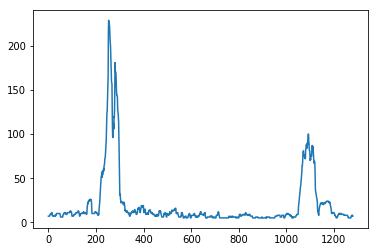

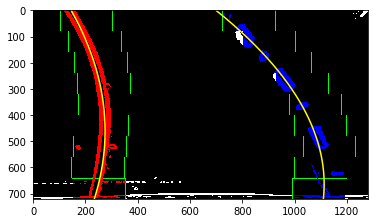

In [34]:
# Use this image as test image. ideally we should have two clear lane lines
trans_image = trans_image_orig

#plt.imshow(trans_image)
print("image shape",trans_image.shape)

#Steps

##1. Get histogram of bottom half of image
# a) set bottom half of picture
y_start = 400

#fig = plt.figure()
#plt.imshow(trans_image[y_start:,:])

# b) next plot histogram, for each, x value, sum y value
hist = np.sum(trans_image[y_start:,:],axis=0)
out_img = np.dstack((trans_image, trans_image, trans_image))*255
fig = plt.figure()
plt.plot(hist)

##2. Get peaks
# a) get midpoint of histogram to seperate left and right
hist_midpt = hist.shape[0]/2
# b) get left lane and right lane start
left_lane_xbase = np.argmax(hist[:hist_midpt])
right_lane_xbase = np.argmax(hist[hist_midpt:])+hist_midpt
print(left_lane_xbase,right_lane_xbase)

##3. Chose number of sliding windows
nwindows = 9

##4. Set height of windows
window_height = trans_image.shape[0] / nwindows
print("window height",window_height)

##5. Identify the x and y positions of all nonzero pixels in the image
nonzero = trans_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
print("nonzero x",nonzerox)

##6 Set current positions. These will be updated for each window
#a) center positions
left_center_x = left_lane_xbase
right_center_x = right_lane_xbase

#b) window size
margin = 100

#c) min pixels
minpix = 50

#d) create empty list to store left and right lane pixels
left_lane_inds = []
right_lane_inds = []

##7 Step through windows one by one

for window in range(nwindows):
    
    #a) calculate window coordinates for left and right lane
    win_y_bottom = trans_image.shape[0] - (window+1)*window_height
    win_y_top = trans_image.shape[0] - window*window_height
    
    #b)left lane
    left_window_x_left_crner = left_center_x - margin
    left_window_x_right_crner = left_center_x + margin
    
    #c)right lane
    right_window_x_left_crner = right_center_x - margin
    right_window_x_right_crner = right_center_x + margin
    
    #d)draw window coordinates
    
    #left lane
    top_left = (left_window_x_left_crner,win_y_top)
    bottom_right = (left_window_x_right_crner,win_y_bottom)
    cv2.rectangle(out_img,top_left,bottom_right,(0,255,0), 2)
    
    #right lane
    top_left = (right_window_x_left_crner,win_y_top)
    bottom_right = (right_window_x_right_crner,win_y_bottom)
    cv2.rectangle(out_img,top_left,bottom_right,(0,255,0), 2)
    
    #e) identify the nonzero pixels within the window
    # y : get non zero between bottom and top of y axis
    # x : get non zero between bottom and top of y axis
    
    # both x and y needs to meet the conditions
    good_left = ((nonzeroy < win_y_top) & (nonzeroy >= win_y_bottom) & (nonzerox <= left_window_x_right_crner) & (nonzerox >= left_window_x_left_crner)).nonzero()[0]
    good_right = ((nonzeroy < win_y_top) & (nonzeroy >= win_y_bottom) & (nonzerox <= right_window_x_right_crner) & (nonzerox >= right_window_x_left_crner)).nonzero()[0]
    
    left_lane_inds.append(good_left)
    right_lane_inds.append(good_right)
    
    #f) recenter windows of found pixels more than threshold
    
    if len(good_left) > minpix:
        #print("num left pixels",len(good_left),nonzerox[good_left])
        #print("total x pixels",len(nonzerox))
        # get indices of nonzero x, then get mean
        left_center_x = np.int(np.mean(nonzerox[good_left]))
    
    if len(good_right) > minpix:
        right_center_x = np.int(np.mean(nonzerox[good_right]))

# 8 Concatenate the array of indices. This will get indices of all non zero pixel
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# 9 Extract left and right line pixel positions
left_lane_x = nonzerox[left_lane_inds]
left_lane_y = nonzeroy[left_lane_inds]

right_lane_x = nonzerox[right_lane_inds]
right_lane_y = nonzeroy[right_lane_inds]

left_fit = np.polyfit(left_lane_y,left_lane_x,2)
right_fit = np.polyfit(right_lane_y,right_lane_x,2)

print("poly fit",left_fit,right_fit)

# Generate x and y values for plotting
# get y values from 0 , 720
ploty = np.linspace(0, trans_image.shape[0]-1, trans_image.shape[0] )
print(len(ploty))
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
fig = plt.figure()
plt.imshow(out_img)
#plot x, y point
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
print("right fit x min and max",min(right_fitx),max(right_fitx))
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [35]:
#calculate curvature

#get max y value

y_max = trans_image.shape[0]
print(y_max)

left_curve = (1 + (2*left_fit[0]*y_max + left_fit[1])**2)**(3/2) / np.abs(2*left_fit[0])

right_curve = (1 + (2*right_fit[0]*y_max + right_fit[1])**2)**(3/2) / np.abs(2*right_fit[0])

print("curvatures",left_curve,right_curve)

720
('curvatures', 901.58943520155674, 540.93697452870322)


In [ ]:
# Define conversions in x and y from pixels space to meters

# Come back to this later

# ym_per_pix = 30/720 # meters per pixel in y dimension
# xm_per_pix = 3.7/700 # meters per pixel in x dimension

# #plt.plot(left_fitx*xm_per_pix,ploty*ym_per_pix)
# plt.plot(left_fitx,ploty)
# # Fit new polynomials to x,y in world space
# left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# # Calculate the new radii of curvature
# left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
# right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# # Now our radius of curvature is in meters
# print(left_curverad, 'm', right_curverad, 'm')

('src points', array([[  560.,   450.],
       [  720.,   450.],
       [ 1190.,   720.],
       [  170.,   720.]], dtype=float32))
('dst points', array([[  100.,   100.],
       [ 1180.,   100.],
       [ 1180.,   720.],
       [  100.,   720.]], dtype=float32))


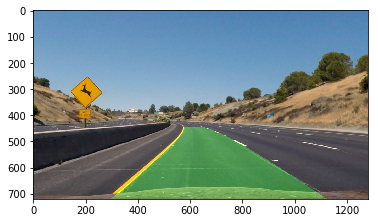

In [37]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(trans_image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

Minv = get_birdeye_invers_matrix(image,src,dst_offset)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [ ]:
# Nice great achievement.

## results also look really cool. really nice lane lines.

## next steps
#1. sliding window - can start from where before
#2. then feed this into a video pipeline.

# i'm also considering prioritizing this later. need more breadth
# need ml and data science. and also strong engineering skills. I think this is a good for domain knowledge.

In [ ]:
# nice great achievement. able to do sliding windows

# next step
# a) fix plot, want to be able to see the boxes being drawn
# b) then see equation of the line
# c) then measure curvature

In [63]:
# Use this image as test image. ideally we should have two clear lane lines
trans_image = trans_image_orig


def calc_lane_lines_best_fit(trans_image,y_start = 400,n_windows=9,margin=100,minpix=50):

    #Steps

    ##1. Get histogram of bottom half of image
    # a) set bottom half of picture
    #y_start = 400

    # b) next plot histogram, for each, x value, sum y value
    hist = np.sum(trans_image[y_start:,:],axis=0)
    out_img = np.dstack((trans_image, trans_image, trans_image))*255
    fig = plt.figure()
    #plt.plot(hist)

    ##2. Get peaks
    # a) get midpoint of histogram to seperate left and right
    hist_midpt = hist.shape[0]/2
    # b) get left lane and right lane start
    left_lane_xbase = np.argmax(hist[:hist_midpt])
    right_lane_xbase = np.argmax(hist[hist_midpt:])+hist_midpt
    #print(left_lane_xbase,right_lane_xbase)

    ##3. Chose number of sliding windows
    #nwindows = 9

    ##4. Set height of windows
    window_height = trans_image.shape[0] / nwindows
    #print("window height",window_height)

    ##5. Identify the x and y positions of all nonzero pixels in the image
    nonzero = trans_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print("nonzero x",nonzerox)

    ##6 Set current positions. These will be updated for each window
    #a) center positions
    left_center_x = left_lane_xbase
    right_center_x = right_lane_xbase

    #b) window size
    #margin = 100

    #c) min pixels
    #minpix = 50

    #d) create empty list to store left and right lane pixels
    left_lane_inds = []
    right_lane_inds = []

    ##7 Step through windows one by one

    for window in range(nwindows):

        #a) calculate window coordinates for left and right lane
        win_y_bottom = trans_image.shape[0] - (window+1)*window_height
        win_y_top = trans_image.shape[0] - window*window_height

        #b)left lane
        left_window_x_left_crner = left_center_x - margin
        left_window_x_right_crner = left_center_x + margin

        #c)right lane
        right_window_x_left_crner = right_center_x - margin
        right_window_x_right_crner = right_center_x + margin

        #d)draw window coordinates

        #left lane
        top_left = (left_window_x_left_crner,win_y_top)
        bottom_right = (left_window_x_right_crner,win_y_bottom)
        cv2.rectangle(out_img,top_left,bottom_right,(0,255,0), 2)

        #right lane
        top_left = (right_window_x_left_crner,win_y_top)
        bottom_right = (right_window_x_right_crner,win_y_bottom)
        cv2.rectangle(out_img,top_left,bottom_right,(0,255,0), 2)

        #e) identify the nonzero pixels within the window
        # y : get non zero between bottom and top of y axis
        # x : get non zero between bottom and top of y axis

        # both x and y needs to meet the conditions
        good_left = ((nonzeroy < win_y_top) & (nonzeroy >= win_y_bottom) & (nonzerox <= left_window_x_right_crner) & (nonzerox >= left_window_x_left_crner)).nonzero()[0]
        good_right = ((nonzeroy < win_y_top) & (nonzeroy >= win_y_bottom) & (nonzerox <= right_window_x_right_crner) & (nonzerox >= right_window_x_left_crner)).nonzero()[0]

        left_lane_inds.append(good_left)
        right_lane_inds.append(good_right)

        #f) recenter windows of found pixels more than threshold

        if len(good_left) > minpix:
            left_center_x = np.int(np.mean(nonzerox[good_left]))

        if len(good_right) > minpix:
            right_center_x = np.int(np.mean(nonzerox[good_right]))

    # 8 Concatenate the array of indices. This will get indices of all non zero pixel
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # 9 Extract left and right line pixel positions
    left_lane_x = nonzerox[left_lane_inds]
    left_lane_y = nonzeroy[left_lane_inds]

    right_lane_x = nonzerox[right_lane_inds]
    right_lane_y = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(left_lane_y,left_lane_x,2)
    right_fit = np.polyfit(right_lane_y,right_lane_x,2)

    #print("poly fit",left_fit,right_fit)

    # Generate x and y values for plotting
    # get y values from 0 , 720
    ploty = np.linspace(0, trans_image.shape[0]-1, trans_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ploty,left_fitx,right_fitx


In [70]:
# How to feed this into a video

# start with multiple images?

# Build function in a way that it takes in an image and then outputs image

def plot_lane_lanes(trans_image,orig_image,left_fitx,right_fitx,ploty):

    '''
    trans_image = input_image
    left_fitx = # get left lane, x values
    right_fitx = # get right lane, x values
    ploty = # plot y is a bunch of y values equal to the height of the image

    '''

    # create zero matrix with shape like image
    warp_zero = np.zeros_like(trans_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = get_birdeye_invers_matrix(orig_image,src,dst_offset)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)

    # return image with plotted lane
    return result


In [71]:
# wrapper

def find_car_lanes(image_undist):
    
    image = image_undist

    # choose to abstract this out. ideally we should get the lane start from the binary images
    src_offset_x_btm_left = 170
    src_offset_x_btm_right = 90
    src_offset_x_top_left = 560
    src_offset_x_top_right = 560
    src_start_y = 450
    dst_offset = 100

    img_size = (image.shape[1],image.shape[0])

    #format x,y
    src = np.float32([ [src_offset_x_top_left,src_start_y],
                                    [img_size[0]-src_offset_x_top_right,src_start_y],
                                    [img_size[0]-src_offset_x_btm_right,img_size[1]],
                                    [src_offset_x_btm_left,img_size[1]]
                                    ])


    #1. apply perspective transform
    trans_image = get_birdeye_image_perspective(image,src,dst_offset)

    combined_img = np.zeros_like(image[:,:,0])
    mag_binary = mag_thresh(trans_image, sobel_kernel=15, mag_thresh=(20, 255))
    color_space_binary = color_space_threshold(trans_image,thresh=(50, 150),color_space = 'HLS',color_channel = 2)


    #combined_mask = (mag_binary>0) & (color_space_binary>0)
    combined_mask = (mag_binary>0)
    combined_img[combined_mask] = 1

    #trans_image = get_birdeye_image_perspective(combined_img,src,dst_offset)
    trans_image = combined_img
    
    
    ploty,left_fitx,right_fitx = calc_lane_lines_best_fit(trans_image)
    return plot_lane_lanes(trans_image,image,left_fitx,right_fitx,ploty)

('poly fit', array([ -6.10262318e-04,   5.61899028e-01,   1.45958807e+02]), array([ -9.34171260e-04,   1.24198089e+00,   7.00050669e+02]))
('src points', array([[  560.,   450.],
       [  720.,   450.],
       [ 1190.,   720.],
       [  170.,   720.]], dtype=float32))
('dst points', array([[  100.,   100.],
       [ 1180.,   100.],
       [ 1180.,   720.],
       [  100.,   720.]], dtype=float32))


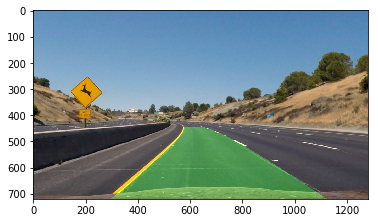

In [58]:
# test function

ploty,left_fitx,right_fitx = calc_lane_lines_best_fit(trans_image)
plt.imshow(plot_lane_lanes(trans_image,image,left_fitx,right_fitx,ploty))

In [72]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(find_car_lanes)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:27,  8.53it/s]

  0%|          | 2/1261 [00:00<02:24,  8.68it/s]

  0%|          | 3/1261 [00:00<02:24,  8.72it/s]

  0%|          | 4/1261 [00:00<02:21,  8.86it/s]

  0%|          | 5/1261 [00:00<02:19,  8.98it/s]

  0%|          | 6/1261 [00:00<02:18,  9.09it/s]

  1%|          | 7/1261 [00:00<02:16,  9.18it/s]

  1%|          | 8/1261 [00:00<02:16,  9.19it/s]

  1%|          | 9/1261 [00:00<02:16,  9.15it/s]

  1%|          | 10/1261 [00:01<02:15,  9.24it/s]

  1%|          | 11/1261 [00:01<02:14,  9.29it/s]

  1%|          | 12/1261 [00:01<02:15,  9.21it/s]

  1%|          | 13/1261 [00:01<02:16,  9.15it/s]

  1%|          | 14/1261 [00:01<02:16,  9.16it/s]

  1%|          | 15/1261 [00:01<02:16,  9.16it/s]

  1%|▏         | 16/1261 [00:01<02:14,  9.26it/s]

  1%|▏         | 17/1261 [00:01<02:15,  9.17it/s]

  1%|▏         | 18/1261 [00:01<02:15,  9.15it/s]

  2%|▏         | 19/1261 [00:02<02:14,  9.21it/

 11%|█▏        | 143/1261 [00:16<02:07,  8.79it/s]

 11%|█▏        | 144/1261 [00:16<02:05,  8.89it/s]

 11%|█▏        | 145/1261 [00:16<02:04,  8.99it/s]

 12%|█▏        | 146/1261 [00:16<02:04,  8.96it/s]

 12%|█▏        | 147/1261 [00:16<02:03,  9.00it/s]

 12%|█▏        | 148/1261 [00:16<02:05,  8.88it/s]

 12%|█▏        | 149/1261 [00:16<02:07,  8.75it/s]

 12%|█▏        | 150/1261 [00:16<02:06,  8.75it/s]

 12%|█▏        | 151/1261 [00:17<02:04,  8.89it/s]

 12%|█▏        | 152/1261 [00:17<02:03,  9.00it/s]

 12%|█▏        | 153/1261 [00:17<02:01,  9.10it/s]

 12%|█▏        | 154/1261 [00:17<02:01,  9.09it/s]

 12%|█▏        | 155/1261 [00:17<02:03,  8.94it/s]

 12%|█▏        | 156/1261 [00:17<02:05,  8.80it/s]

 12%|█▏        | 157/1261 [00:17<02:04,  8.86it/s]

 13%|█▎        | 158/1261 [00:17<02:02,  9.00it/s]

 13%|█▎        | 159/1261 [00:17<02:02,  9.02it/s]

 13%|█▎        | 160/1261 [00:18<02:01,  9.07it/s]

 13%|█▎        | 161/1261 [00:18<01:59,  9.18it/s]

 13%|█▎     

 23%|██▎       | 284/1261 [00:31<01:49,  8.94it/s]

 23%|██▎       | 285/1261 [00:32<01:48,  8.97it/s]

 23%|██▎       | 286/1261 [00:32<01:48,  9.01it/s]

 23%|██▎       | 287/1261 [00:32<01:49,  8.90it/s]

 23%|██▎       | 288/1261 [00:32<01:50,  8.84it/s]

 23%|██▎       | 289/1261 [00:32<01:49,  8.85it/s]

 23%|██▎       | 290/1261 [00:32<01:49,  8.84it/s]

 23%|██▎       | 291/1261 [00:32<01:49,  8.82it/s]

 23%|██▎       | 292/1261 [00:32<01:49,  8.87it/s]

 23%|██▎       | 293/1261 [00:32<01:48,  8.92it/s]

 23%|██▎       | 294/1261 [00:33<01:49,  8.82it/s]

 23%|██▎       | 295/1261 [00:33<01:57,  8.25it/s]

 23%|██▎       | 296/1261 [00:33<01:54,  8.43it/s]

 24%|██▎       | 297/1261 [00:33<01:50,  8.69it/s]

 24%|██▎       | 298/1261 [00:33<01:49,  8.78it/s]

 24%|██▎       | 299/1261 [00:33<01:47,  8.91it/s]

 24%|██▍       | 300/1261 [00:33<01:46,  8.99it/s]

 24%|██▍       | 301/1261 [00:33<01:46,  8.98it/s]

 24%|██▍       | 302/1261 [00:33<01:57,  8.18it/s]

 24%|██▍    

 34%|███▎      | 425/1261 [00:48<01:49,  7.65it/s]

 34%|███▍      | 426/1261 [00:48<01:48,  7.71it/s]

 34%|███▍      | 427/1261 [00:48<01:47,  7.78it/s]

 34%|███▍      | 428/1261 [00:48<01:45,  7.89it/s]

 34%|███▍      | 429/1261 [00:49<01:43,  8.03it/s]

 34%|███▍      | 430/1261 [00:49<01:41,  8.19it/s]

 34%|███▍      | 431/1261 [00:49<01:39,  8.35it/s]

 34%|███▍      | 432/1261 [00:49<01:38,  8.44it/s]

 34%|███▍      | 433/1261 [00:49<01:37,  8.47it/s]

 34%|███▍      | 434/1261 [00:49<01:37,  8.49it/s]

 34%|███▍      | 435/1261 [00:49<01:37,  8.49it/s]

 35%|███▍      | 436/1261 [00:49<01:37,  8.44it/s]

 35%|███▍      | 437/1261 [00:49<01:37,  8.46it/s]

 35%|███▍      | 438/1261 [00:50<01:38,  8.34it/s]

 35%|███▍      | 439/1261 [00:50<02:14,  6.12it/s]

 35%|███▍      | 440/1261 [00:50<02:06,  6.46it/s]

 35%|███▍      | 441/1261 [00:50<01:58,  6.92it/s]

 35%|███▌      | 442/1261 [00:50<01:52,  7.27it/s]

 35%|███▌      | 443/1261 [00:50<01:48,  7.51it/s]

 35%|███▌   

 45%|████▍     | 566/1261 [01:06<01:45,  6.61it/s]

 45%|████▍     | 567/1261 [01:06<01:37,  7.10it/s]

 45%|████▌     | 568/1261 [01:06<01:33,  7.42it/s]

 45%|████▌     | 569/1261 [01:06<01:30,  7.68it/s]

 45%|████▌     | 570/1261 [01:06<01:27,  7.93it/s]

 45%|████▌     | 571/1261 [01:07<01:24,  8.13it/s]

 45%|████▌     | 572/1261 [01:07<01:24,  8.16it/s]

 45%|████▌     | 573/1261 [01:07<01:23,  8.27it/s]

 46%|████▌     | 574/1261 [01:07<01:23,  8.22it/s]

 46%|████▌     | 575/1261 [01:07<01:28,  7.71it/s]

 46%|████▌     | 576/1261 [01:07<01:27,  7.80it/s]

 46%|████▌     | 577/1261 [01:07<01:26,  7.89it/s]

 46%|████▌     | 578/1261 [01:07<01:25,  8.03it/s]

 46%|████▌     | 579/1261 [01:08<01:53,  6.00it/s]

 46%|████▌     | 580/1261 [01:08<01:45,  6.45it/s]

 46%|████▌     | 581/1261 [01:08<01:41,  6.69it/s]

 46%|████▌     | 582/1261 [01:08<01:34,  7.18it/s]

 46%|████▌     | 583/1261 [01:08<01:27,  7.72it/s]

 46%|████▋     | 584/1261 [01:08<01:23,  8.10it/s]

 46%|████▋  

 56%|█████▌    | 707/1261 [01:24<01:12,  7.66it/s]

 56%|█████▌    | 708/1261 [01:24<01:22,  6.69it/s]

 56%|█████▌    | 709/1261 [01:24<01:33,  5.90it/s]

 56%|█████▋    | 710/1261 [01:24<01:24,  6.50it/s]

 56%|█████▋    | 711/1261 [01:24<01:17,  7.07it/s]

 56%|█████▋    | 712/1261 [01:24<01:13,  7.44it/s]

 57%|█████▋    | 713/1261 [01:25<01:12,  7.60it/s]

 57%|█████▋    | 714/1261 [01:25<01:11,  7.70it/s]

 57%|█████▋    | 715/1261 [01:25<01:10,  7.76it/s]

 57%|█████▋    | 716/1261 [01:25<01:11,  7.63it/s]

 57%|█████▋    | 717/1261 [01:25<01:14,  7.35it/s]

 57%|█████▋    | 718/1261 [01:25<01:13,  7.35it/s]

 57%|█████▋    | 719/1261 [01:25<01:16,  7.12it/s]

 57%|█████▋    | 720/1261 [01:26<01:14,  7.24it/s]

 57%|█████▋    | 721/1261 [01:26<01:11,  7.59it/s]

 57%|█████▋    | 722/1261 [01:26<01:10,  7.69it/s]

 57%|█████▋    | 723/1261 [01:26<01:07,  7.92it/s]

 57%|█████▋    | 724/1261 [01:26<01:07,  7.93it/s]

 57%|█████▋    | 725/1261 [01:26<01:25,  6.25it/s]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [01:42<00:51,  8.05it/s]

 67%|██████▋   | 849/1261 [01:42<00:50,  8.09it/s]

 67%|██████▋   | 850/1261 [01:42<00:51,  8.06it/s]

 67%|██████▋   | 851/1261 [01:42<00:50,  8.06it/s]

 68%|██████▊   | 852/1261 [01:42<00:52,  7.80it/s]

 68%|██████▊   | 853/1261 [01:42<00:52,  7.82it/s]

 68%|██████▊   | 854/1261 [01:42<00:51,  7.92it/s]

 68%|██████▊   | 855/1261 [01:43<00:51,  7.91it/s]

 68%|██████▊   | 856/1261 [01:43<00:51,  7.85it/s]

 68%|██████▊   | 857/1261 [01:43<00:50,  7.96it/s]

 68%|██████▊   | 858/1261 [01:43<00:49,  8.14it/s]

 68%|██████▊   | 859/1261 [01:43<00:49,  8.20it/s]

 68%|██████▊   | 860/1261 [01:43<00:48,  8.31it/s]

 68%|██████▊   | 861/1261 [01:43<00:48,  8.18it/s]

 68%|██████▊   | 862/1261 [01:43<00:50,  7.90it/s]

 68%|██████▊   | 863/1261 [01:44<00:52,  7.65it/s]

 69%|██████▊   | 864/1261 [01:44<00:51,  7.64it/s]

 69%|██████▊   | 865/1261 [01:44<00:50,  7.80it/s]

 69%|██████▊   | 866/1261 [01:44<00:50,  7.85it/s]

 69%|██████▉

 78%|███████▊  | 989/1261 [01:59<00:33,  8.09it/s]

 79%|███████▊  | 990/1261 [01:59<00:33,  8.14it/s]

 79%|███████▊  | 991/1261 [01:59<00:32,  8.34it/s]

 79%|███████▊  | 992/1261 [01:59<00:31,  8.52it/s]

 79%|███████▊  | 993/1261 [01:59<00:31,  8.55it/s]

 79%|███████▉  | 994/1261 [01:59<00:30,  8.87it/s]

 79%|███████▉  | 995/1261 [02:00<00:29,  9.03it/s]

 79%|███████▉  | 996/1261 [02:00<00:29,  9.00it/s]

 79%|███████▉  | 997/1261 [02:00<00:28,  9.20it/s]

 79%|███████▉  | 998/1261 [02:00<00:28,  9.24it/s]

 79%|███████▉  | 999/1261 [02:00<00:28,  9.13it/s]

 79%|███████▉  | 1000/1261 [02:00<00:28,  9.28it/s]

 79%|███████▉  | 1001/1261 [02:00<00:28,  9.08it/s]

 79%|███████▉  | 1002/1261 [02:00<00:28,  8.96it/s]

 80%|███████▉  | 1003/1261 [02:00<00:28,  8.92it/s]

 80%|███████▉  | 1004/1261 [02:01<00:28,  8.88it/s]

 80%|███████▉  | 1005/1261 [02:01<00:28,  8.86it/s]

 80%|███████▉  | 1006/1261 [02:01<00:29,  8.74it/s]

 80%|███████▉  | 1007/1261 [02:01<00:29,  8.72it/s]

 80%

 89%|████████▉ | 1128/1261 [02:15<00:14,  9.28it/s]

 90%|████████▉ | 1129/1261 [02:15<00:14,  9.26it/s]

 90%|████████▉ | 1130/1261 [02:15<00:14,  9.27it/s]

 90%|████████▉ | 1131/1261 [02:15<00:14,  9.20it/s]

 90%|████████▉ | 1132/1261 [02:15<00:14,  9.13it/s]

 90%|████████▉ | 1133/1261 [02:15<00:14,  9.01it/s]

 90%|████████▉ | 1134/1261 [02:15<00:14,  9.07it/s]

 90%|█████████ | 1135/1261 [02:15<00:13,  9.03it/s]

 90%|█████████ | 1136/1261 [02:15<00:13,  9.15it/s]

 90%|█████████ | 1137/1261 [02:16<00:13,  9.19it/s]

 90%|█████████ | 1138/1261 [02:16<00:13,  9.09it/s]

 90%|█████████ | 1139/1261 [02:16<00:13,  9.17it/s]

 90%|█████████ | 1140/1261 [02:16<00:13,  9.18it/s]

 90%|█████████ | 1141/1261 [02:16<00:12,  9.25it/s]

 91%|█████████ | 1142/1261 [02:16<00:12,  9.28it/s]

 91%|█████████ | 1143/1261 [02:16<00:12,  9.34it/s]

 91%|█████████ | 1144/1261 [02:16<00:12,  9.35it/s]

 91%|█████████ | 1145/1261 [02:16<00:12,  9.39it/s]

 91%|█████████ | 1146/1261 [02:17<00:12,  9.40

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 2min 36s, sys: 33.9 s, total: 3min 10s
Wall time: 2min 30s


In [73]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))